In [24]:
# Imports
import librosa, librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import math
import json
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import pickle
import tensorflow as tf

In [25]:
# Load data
DATA_PATH = "JSON/TrainData.json"

SAMPLE_RATE = 22050
DURATION = 4
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def load_audio_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [26]:
# Split data
def prepare_datasets(validation_size, X, y):

    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    
    return X_train, X_validation, y_train, y_validation

In [27]:
# CNN model
def build_model(input_shape):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))                                
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu')) 
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))   
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))                                
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(192, activation='relu'))
    model.add(keras.layers.Dropout(0.05))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.05))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(160, activation='relu'))
    model.add(keras.layers.Dropout(0.05))
    model.add(keras.layers.Dense(480, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    return model

In [28]:
# Train/Test Split data
validation_size = 0.2

X_audio, y_audio = load_audio_data(DATA_PATH)

# with open('X_audio.pickle', 'wb') as f:
#     pickle.dump(X_audio, f)
# with open('y_audio.pickle', 'wb') as f:
#     pickle.dump(y_audio, f)

X_audio_train, X_audio_validation, y_audio_train, y_audio_validation = prepare_datasets(validation_size, X_audio, y_audio)

In [29]:
# Audio train
audio_input_shape = (X_audio_train.shape[1], X_audio_train.shape[2], X_audio_train.shape[3])
audio_model = build_model(audio_input_shape)

audio_optimizer = keras.optimizers.Adam(learning_rate=0.00110654178783952)

audio_model.compile(optimizer=audio_optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

audio_model.summary()

audio_history = audio_model.fit(X_audio_train, y_audio_train, batch_size=4, epochs=15, validation_data=(X_audio_validation, y_audio_validation))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 171, 11, 16)       160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 169, 9, 16)        2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 85, 5, 16)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 85, 5, 16)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 83, 3, 16)         2320      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 81, 1, 64)         9280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 41, 1, 64)        

Text(0.5, 1.0, 'Audio Accuracy Curves')

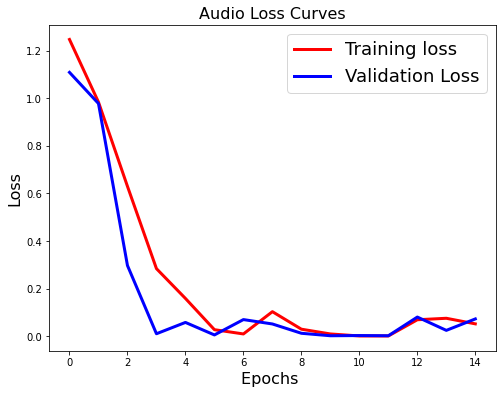

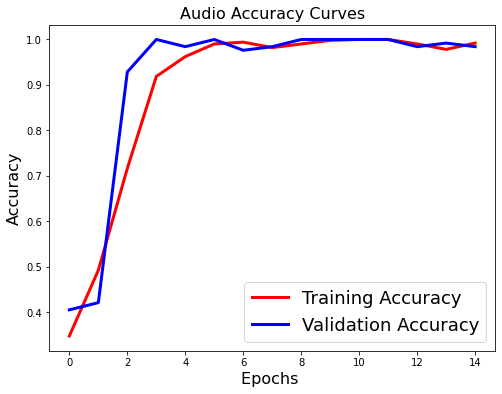

In [30]:
#Audio Loss Curves
plt.figure(figsize=[8,6])
plt.plot(audio_history.history['loss'],'r',linewidth=3.0)
plt.plot(audio_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Audio Loss Curves',fontsize=16)

#Audio Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(audio_history.history['accuracy'],'r',linewidth=3.0)
plt.plot(audio_history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Audio Accuracy Curves',fontsize=16)

In [31]:
# Save model
audio_model.save("Models/CNNaudioClassifierV1.model")

INFO:tensorflow:Assets written to: Models/CNNaudioClassifierV1.model\assets


In [32]:
audio_model = tf.keras.models.load_model('Models/CNNaudioClassifierV1.model')

In [33]:
# Retrive data
X, y = load_audio_data("JSON/Test_audio.json")

# Fit image data
X = X[..., np.newaxis]
audio_test_error, audio_test_accuracy = audio_model.evaluate(X, y, verbose=1)
print("Audio test set accuracy: {}%".format(audio_test_accuracy*100))

3/3 [==============================] - 0s 9ms/step - loss: 1.3355 - accuracy: 0.8352
Audio test set accuracy: 83.51648449897766%


In [34]:
s = (-1, X.shape[1], X.shape[2], 1)
print(s)
# Fit audio data
a = X[0].reshape(s)

# Predict audio
audio_predictions = audio_model.predict(a)
print(audio_predictions)

(-1, 173, 13, 1)
[[1.0000000e+00 4.7408536e-15 1.2713004e-14]]
